In [1]:
# Installing Pillow Libraries
!pip install scikit-learn matplotlib Pillow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [4]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [6]:
dirpath = 'SMAI-Dataset-release/IIIT-CFW/IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


# 1.1 - PCA

## 1.1.1 - plot cummalative explained variance 

[[0.09416836 0.08631895 0.08103604 ... 0.04221782 0.04142305 0.0425173 ]
 [0.08631895 0.0962554  0.09226675 ... 0.04173321 0.04545413 0.04559659]
 [0.08103604 0.09226675 0.10146832 ... 0.04163747 0.04461936 0.04981359]
 ...
 [0.04221782 0.04173321 0.04163747 ... 0.09629671 0.08793316 0.08208861]
 [0.04142305 0.04545413 0.04461936 ... 0.08793316 0.09772433 0.09532329]
 [0.0425173  0.04559659 0.04981359 ... 0.08208861 0.09532329 0.10708641]]
[[ 0.02292623 -0.02281108  0.00362127 ...  0.          0.
   0.        ]
 [ 0.02397955 -0.02519623  0.0062778  ...  0.01539164 -0.09674685
  -0.29344519]
 [ 0.02493145 -0.02346326  0.00936172 ...  0.05483024  0.02042223
   0.47810165]
 ...
 [ 0.02018243 -0.01026555  0.02086738 ... -0.01084632  0.00575024
  -0.01389049]
 [ 0.02059623 -0.01334157  0.02756402 ...  0.01869906 -0.03547637
   0.00630939]
 [ 0.02169246 -0.01293336  0.0293959  ... -0.01267691  0.01985989
   0.00612859]]
(3072, 3072)


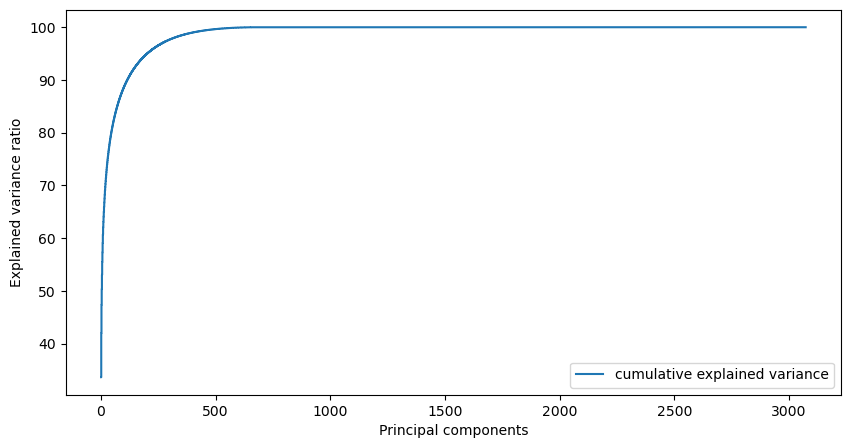

In [9]:
# N,H,W = X.shape[0:3]
# C = 1 if opt['is_grayscale'] else X.shape[3]

# ind = np.random.randint(0,y.shape[0],6)
# display_images(X[ind,...],y[ind], row=2,col=3)

# flatten data
X = X.flatten().reshape(X.shape[0],-1)

# mean normalization
X = X - np.mean(X,axis=0)
# X/=np.std(X,axis=0)
# print(X)
# covariance matrix
cov = np.cov(X,rowvar=False) # rowvar=False means each column represents a variable
# print(cov)
# eigen values and eigen vectors
eig_vals,eig_vecs = np.linalg.eigh(cov) # discard imag. value

# sort eigen values in descending order
sorted_index = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sorted_index]
eig_vecs = eig_vecs[:,sorted_index] # returns eigen vectors as column vectors
print(eig_vecs)
print(eig_vecs.shape)
total = np.sum(eig_vals)
var_exp = [(i/total)*100 for i in eig_vals]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 5))
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()



### y-axis is the variance covered by the first k components, so as k increases, the variance covered increases and only initial 672 components are needed to cover 100% of the variance

## 1.1.2 - Dimensionality Reduction on given dataset

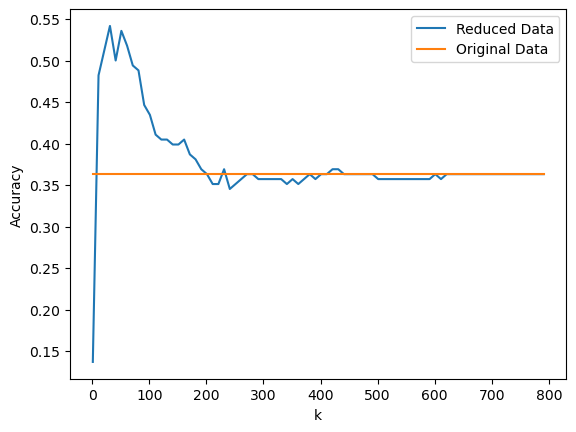

In [13]:
# use external classifier to compare the accuracy of projected data with original data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# plot k vs accuracy
k_list = range(1,800,10)
accuracy_list_reduced_data = []
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
oreginal_data_accuracy = accuracy_score(y_test,y_pred)

for k in k_list:
    # select top k eigen vectors
    new_eig_vecs = eig_vecs[:,:k]

    # project data
    X_proj = np.dot(X,new_eig_vecs)

    X_train,X_test,y_train,y_test = train_test_split(X_proj,y,test_size=0.25,random_state=42)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    accuracy_list_reduced_data.append(accuracy_score(y_test,y_pred))

plt.plot(k_list,accuracy_list_reduced_data,label='Reduced Data')
plt.plot(k_list,[oreginal_data_accuracy]*len(k_list),label='Original Data')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




## 1.1.3 - Dimensionality Reduction on assignment-1 dataset

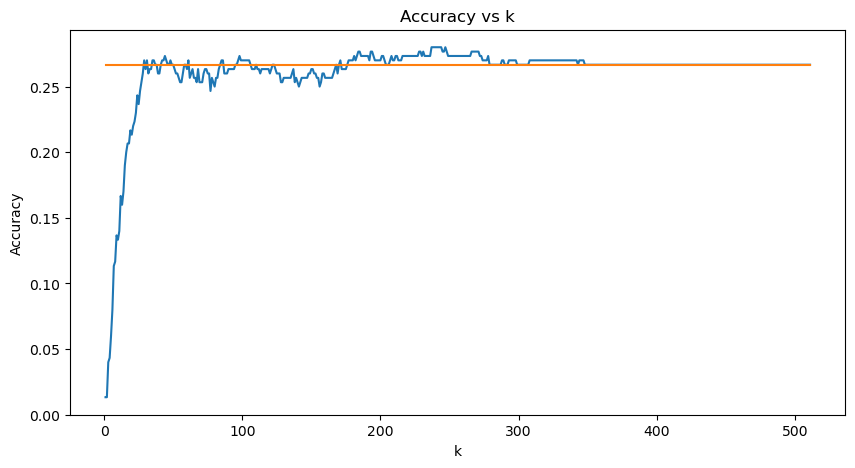

0.28


In [25]:


pictionary_dataset = np.load('data.npy',allow_pickle=True)
labels = []
VIT_encoding = []
for i in range(len(pictionary_dataset)):
    labels.append(pictionary_dataset[i][3])
    VIT_encoding.append(pictionary_dataset[i][2])
labels = np.array(labels)
VIT_encoding = np.array(VIT_encoding).reshape(len(pictionary_dataset),-1)


# mean normalization
VIT_encoding = VIT_encoding - np.mean(VIT_encoding,axis=0)

# covariance matrix
cov = np.cov(VIT_encoding,rowvar=False)

# eigen values and eigen vectors
eig_vals,eig_vecs = np.linalg.eigh(cov)

# sort eigen values in descending order
sorted_index = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sorted_index]
eig_vecs = eig_vecs[:,sorted_index] # sort eigen vectors according to eigen values

# before reduction
X_train,X_test,y_train,y_test = train_test_split(VIT_encoding,labels,test_size=0.2,random_state=42)

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=10,metric='euclidean',weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_pictionary = accuracy_score(y_test, y_pred)

# after reduction
k_list = range(1, 512,1)
accuracy_list_pictionary = []
for k in k_list:
    # select top k eigen vectors
    new_eig_vecs = eig_vecs[:,:k]

    # project data
    X_proj = np.dot(VIT_encoding,new_eig_vecs)

    X_train,X_test,y_train,y_test = train_test_split(X_proj,labels,test_size=0.2,random_state=42)

    knn = KNeighborsClassifier(n_neighbors=10,metric='euclidean',weights='distance')
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    accuracy_list_pictionary.append(accuracy_score(y_test,y_pred))

plt.figure(figsize=(10, 5))
plt.plot(k_list,accuracy_list_pictionary)
plt.plot(k_list,[accuracy_pictionary]*len(k_list))
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()


### The accuracy becomes almost same as the original dataset when the number of components is around 350. Before that, the accuracy is near to the actual but it might greater or less because the features of dataset are not same as the features of the original dataset.

# 1.2 - Dimensionality Reduction on pictionary dataset

## 1.2.1 - plot 1,2,3 components of PCA for drawer and guesser 

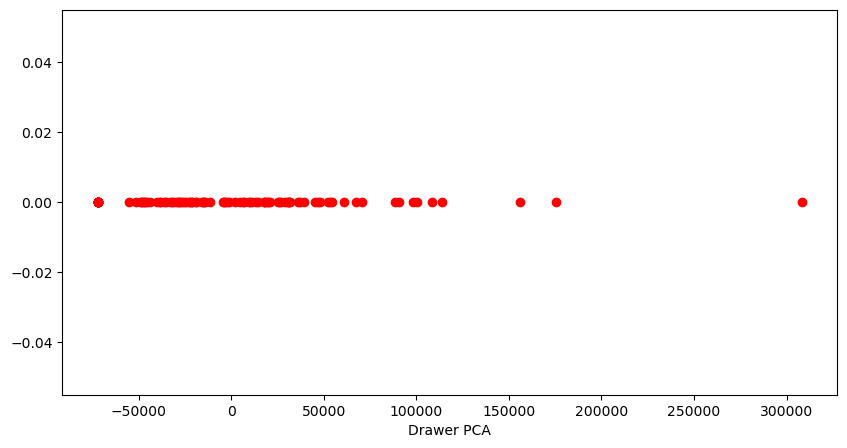

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
drawer_data = pd.read_csv('drawer_attributes.csv')
guesser_data = pd.read_csv('guesser_attributes.csv')

# print(drawer_data)
# drop unnecessary columns
drawer_data = drawer_data.drop(['d_drawer'],axis=1)
guesser_data = guesser_data.drop(['g_guesser'],axis=1)

# convert to numpy array
drawer_data = np.array(drawer_data)
guesser_data = np.array(guesser_data)

# mean normalization
drawer_data = drawer_data - np.mean(drawer_data,axis=0)
guesser_data = guesser_data - np.mean(guesser_data,axis=0)

# covariance matrix
cov_drawer = np.cov(drawer_data,rowvar=False)
cov_guesser = np.cov(guesser_data,rowvar=False)

# eigen values and eigen vectors
eig_vals_drawer,eig_vecs_drawer = np.linalg.eigh(cov_drawer)
eig_vals_guesser,eig_vecs_guesser = np.linalg.eigh(cov_guesser)

# sort eigen values in descending order
sorted_index_drawer = np.argsort(eig_vals_drawer)[::-1]
sorted_index_guesser = np.argsort(eig_vals_guesser)[::-1]
eig_vals_drawer = eig_vals_drawer[sorted_index_drawer]
eig_vals_guesser = eig_vals_guesser[sorted_index_guesser]

# sort eigen vectors according to eigen values
eig_vecs_drawer = eig_vecs_drawer[:,sorted_index_drawer]
eig_vecs_guesser = eig_vecs_guesser[:,sorted_index_guesser] 



In [ ]:
# drawer_pca for only 1 component
drawer_pca = np.dot(drawer_data,eig_vecs_drawer[:,0])

# plot the 1-d data
plt.figure(figsize=(10, 5))
plt.scatter(drawer_pca,np.zeros(drawer_pca.shape),c='red')
plt.xlabel('Drawer PCA')
plt.show()

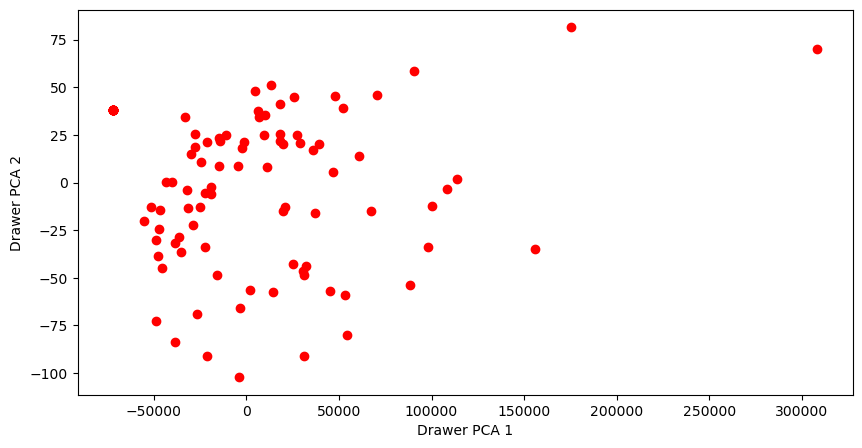

In [6]:
# drawer_pca for 2 components
drawer_pca = np.dot(drawer_data,eig_vecs_drawer[:,0:2])

# plot the 2-d data
plt.figure(figsize=(10, 5))
plt.scatter(drawer_pca[:,0],drawer_pca[:,1],c='red')
plt.xlabel('Drawer PCA 1')
plt.ylabel('Drawer PCA 2')
plt.show()


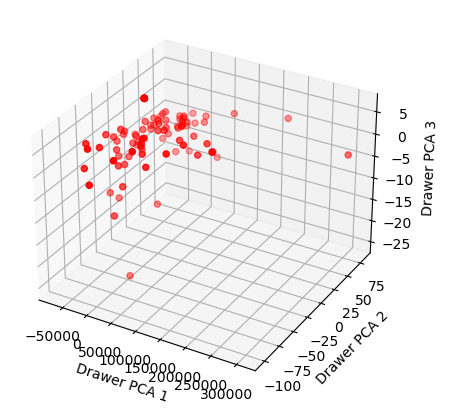

In [9]:
# drawer_pca for 3 components
drawer_pca = np.dot(drawer_data,eig_vecs_drawer[:,0:3])

# plot the 3-d data
plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
ax.scatter3D(drawer_pca[:,0],drawer_pca[:,1],drawer_pca[:,2],c='red')
ax.set_xlabel('Drawer PCA 1')
ax.set_ylabel('Drawer PCA 2')
ax.set_zlabel('Drawer PCA 3')
plt.show()

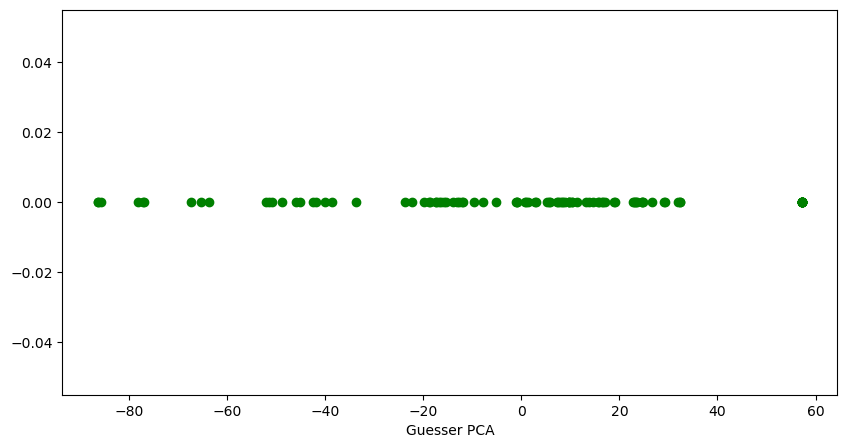

In [10]:
# guesser_pca for only 1 component
guesser_pca = np.dot(guesser_data,eig_vecs_guesser[:,0])

# plot the 1-d data
plt.figure(figsize=(10, 5))
plt.scatter(guesser_pca,np.zeros(guesser_pca.shape),c='green')
plt.xlabel('Guesser PCA')
plt.show()


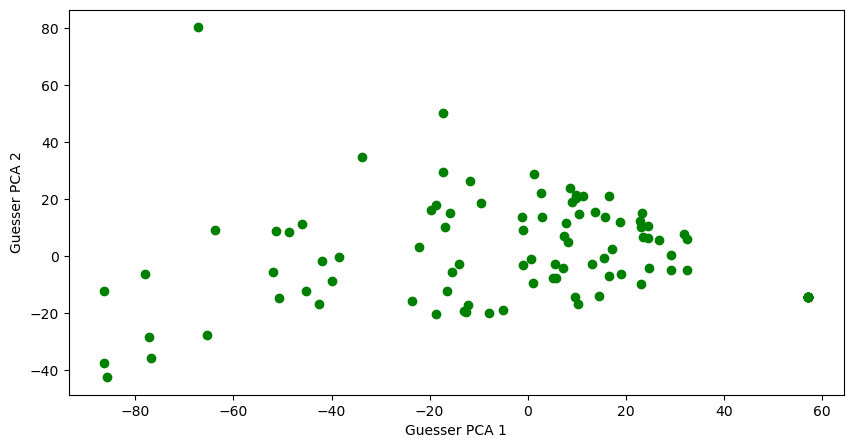

In [11]:
# guesser_pca for 2 components
guesser_pca = np.dot(guesser_data,eig_vecs_guesser[:,0:2])

# plot the 2-d data
plt.figure(figsize=(10, 5))
plt.scatter(guesser_pca[:,0],guesser_pca[:,1],c='green')
plt.xlabel('Guesser PCA 1')
plt.ylabel('Guesser PCA 2')
plt.show()

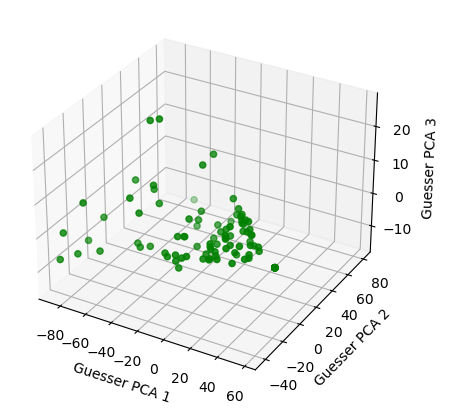

In [13]:
# guesser_pca for 3 components
guesser_pca = np.dot(guesser_data,eig_vecs_guesser[:,0:3])

# plot the 3-d data
plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
ax.scatter3D(guesser_pca[:,0],guesser_pca[:,1],guesser_pca[:,2],c='green')
ax.set_xlabel('Guesser PCA 1')
ax.set_ylabel('Guesser PCA 2')
ax.set_zlabel('Guesser PCA 3')
plt.show()

## 1.2.2 - Observations on the PCA axis

### The new axes obtained represent the principal components of the data. These components are linear combinations of the original features and are ordered by the amount of variance they explain in the data.